<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Jet_Classification_with_different_Initialization_Techniques%20v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane h5py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 77.4 MB/s eta 0:00:00


In [2]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass, field
from sklearn.metrics import (accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix)
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# --- Cell 2: Configuration / Hyperparameter Setup ---
@dataclass
class Config:
    SAMPLES: int = 5000  # Reduced dataset size
    NUM_QUBITS: int = 4  # Reduced number of qubits
    Q_DEPTH: int = 2  # Reduced circuit depth
    ENCODING_SCHEME: str = 'angle'  # Keep angle encoding for simplicity
    USE_ANALYTIC_GRADIENTS: bool = True
    CNN_OUTPUT_DIM: int = 512  # Increased CNN output dimension
    USE_PRETRAINED_CNN: bool = True
    INNER_STEPS: int = 4  # Reduced inner-loop adaptation steps
    INNER_LR: float = 0.005
    OUTER_LR: float = 0.0003  # Reduced outer learning rate
    META_TASK_TYPE: List[str] = field(default_factory=lambda: ['pt', 'm0'])
    META_BIN_COUNT: int = 5  # Reduced number of bins
    SUPPORT_SIZE: int = 24
    QUERY_SIZE: int = 24
    EPOCHS: int = 10  # Reduced number of epochs
    BATCH_SIZE: int = 24
    EVAL_METRICS: bool = True
    SAVE_BEST_MODEL: bool = True
    CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'

config = Config()
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

In [5]:
# --- Cell 3: Dataset Loading ---
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_and_merge_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and merge datasets for meta-task generation."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'

    # Load train and test1 datasets
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    with h5py.File(test1_path, 'r') as f:
        X_test1 = f['X_jets'][:config.SAMPLES]
        y_test1 = f['y'][:config.SAMPLES]
        pt_test1 = f['pt'][:config.SAMPLES]
        m0_test1 = f['m0'][:config.SAMPLES]

    # Merge train and test1
    X_meta = np.concatenate([X_train, X_test1], axis=0)
    y_meta = np.concatenate([y_train, y_test1], axis=0)
    pt_meta = np.concatenate([pt_train, pt_test1], axis=0)
    m0_meta = np.concatenate([m0_train, m0_test1], axis=0)

    # Create dataset
    meta_dataset = JetDataset(X_meta, y_meta, pt_meta, m0_meta)
    return meta_dataset

# Load datasets
meta_dataset = load_and_merge_datasets(config)

In [6]:
# --- Cell 4: Meta-Task Generation ---
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_types: List[str],  # List of meta-task types (e.g., ['pt', 'm0'])
    bin_count: int,
    support_size: int,
    query_size: int,
    num_tasks_per_bin: int = 3,  # Generate multiple tasks per bin
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks using both `pt` and `m0` features for diversity.
    Args:
        dataset: The dataset containing jet images and features.
        meta_task_types: List of meta-task types to use (e.g., ['pt', 'm0']).
        bin_count: Number of bins for meta-task generation.
        support_size: Size of the support set.
        query_size: Size of the query set.
        num_tasks_per_bin: Number of tasks to generate per bin.
    Returns:
        List of meta-tasks, each containing support and query sets.
    """
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    meta_tasks = []
    bin_task_counts = []

    # Alternate between `pt` and `m0` for meta-task generation
    for feature_type in meta_task_types:
        feature = getattr(dataset, feature_type)
        bins = np.linspace(feature.min(), feature.max(), bin_count + 1)
        for i in range(len(bins) - 1):
            bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
            if len(bin_indices) < support_size + query_size:
                continue  # Skip bins with insufficient samples

            # Ensure balanced classes in support and query sets
            class_0_indices = bin_indices[y[bin_indices] == 0]
            class_1_indices = bin_indices[y[bin_indices] == 1]
            if len(class_0_indices) < support_size // 2 or len(class_1_indices) < support_size // 2:
                continue  # Skip bins with insufficient samples for balanced classes

            for _ in range(num_tasks_per_bin):
                support_indices = np.concatenate([
                    np.random.choice(class_0_indices, support_size // 2, replace=False),
                    np.random.choice(class_1_indices, support_size // 2, replace=False),
                ])
                query_indices = np.concatenate([
                    np.random.choice(class_0_indices, query_size // 2, replace=False),
                    np.random.choice(class_1_indices, query_size // 2, replace=False),
                ])
                meta_tasks.append({
                    "support_X": torch.tensor(X[support_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                    "query_X": torch.tensor(X[query_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "query_y": torch.tensor(y[query_indices], dtype=torch.long),
                })
            bin_task_counts.append(num_tasks_per_bin)

    print(f"Total meta-tasks generated: {len(meta_tasks)}")
    return meta_tasks

# Generate meta-tasks using both `pt` and `m0`
meta_task_types = ['pt', 'm0']  # Use both features for meta-task generation
meta_tasks = generate_meta_tasks(
    meta_dataset,
    meta_task_types=meta_task_types,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)

Total meta-tasks generated: 24


In [7]:
# --- Cell 5: CNN Feature Extractor ---
class CNNFeatureExtractor(nn.Module):
    """CNN-based feature extractor using pretrained ResNet-18."""
    def __init__(self, output_dim: int, num_qubits: int):
        super(CNNFeatureExtractor, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, output_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(output_dim, num_qubits)  # Use num_qubits passed as an argument
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

# Instantiate the CNN feature extractor with the correct arguments
cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.2MB/s]


In [8]:
# --- Cell 6: PQC Model ---
class PQCModel(nn.Module):
    """Parameterized Quantum Circuit (PQC) model."""
    def __init__(self, num_qubits: int, depth: int, init_type: str = "qmaml"):
        super(PQCModel, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
            # Angle encoding
            for i in range(num_qubits):
                qml.RY(inputs[i], wires=i)
            # Variational layers
            qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return qml.expval(qml.PauliZ(0))  # Expectation value of Z on the first qubit

        self.circuit = circuit

        # Initialize weights based on init_type
        if init_type == "zero":
            self.weights = nn.Parameter(torch.zeros(depth, num_qubits, 3))
        elif init_type == "pi":
            self.weights = nn.Parameter(torch.full((depth, num_qubits, 3), np.pi))
        elif init_type == "uniform":
            self.weights = nn.Parameter(torch.rand(depth, num_qubits, 3) * 0.05 * np.pi)
        elif init_type == "gaussian":
            gamma = 1 / (4 * num_qubits * (depth + 2))
            self.weights = nn.Parameter(torch.normal(0, gamma, size=(depth, num_qubits, 3)))
        else:  # Default to QMAML initialization
            self.weights = nn.Parameter(torch.randn(depth, num_qubits, 3))

        self.fc = nn.Linear(1, 2)  # Map scalar output to two logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1)  # Placeholder for quantum outputs
        for i in range(batch_size):
            outputs[i] = self.circuit(x[i], self.weights)
        logits = self.fc(outputs)
        return logits

In [9]:
# --- Cell 7: Hybrid Model ---
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super(HybridModel, self).__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

In [10]:
# --- Cell 8: Inner-Loop Adaptation ---
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> nn.Module:
    """Perform inner-loop adaptation on the support set."""
    adapted_model = HybridModel(model.cnn, model.pqc)  # Clone the model
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    loss_fn = nn.CrossEntropyLoss()
    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()
        optimizer.step()
    return adapted_model

In [14]:
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool
) -> Dict[str, List[float]]:
    """
    Perform outer-loop meta-update using meta-tasks.

    Args:
        model (nn.Module): The hybrid model (e.g., CNN + PQC).
        meta_tasks (List[Dict[str, Any]]): List of meta-tasks containing support and query sets.
        outer_lr (float): Outer-loop learning rate.
        eval_metrics (bool): Whether to calculate evaluation metrics (accuracy, precision, recall, F1).

    Returns:
        Dict[str, List[float]]: Dictionary containing meta-loss history and evaluation metrics.
    """
    # Optimizer for the outer loop
    optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    # History tracking
    meta_loss_history = []
    metrics_history = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_accuracy = 0.0  # For saving the best model

    for epoch in range(config.EPOCHS):
        meta_loss = 0.0
        epoch_accuracies, epoch_precisions, epoch_recalls, epoch_f1s = [], [], [], []

        for task in meta_tasks:
            # Inner-loop adaptation
            adapted_model = inner_loop_adaptation(
                model,
                task["support_X"],
                task["support_y"],
                config.INNER_STEPS,
                config.INNER_LR
            )

            # Evaluate on query set
            query_logits = adapted_model(task["query_X"])
            query_loss = loss_fn(query_logits, task["query_y"])
            meta_loss += query_loss.item()

            # Backpropagate meta-loss
            optimizer.zero_grad()
            query_loss.backward()
            optimizer.step()

            # Track per-task metrics
            if eval_metrics:
                preds = torch.argmax(query_logits, dim=1)
                accuracy = (preds == task["query_y"]).float().mean().item()
                precision = precision_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                recall = recall_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                f1 = f1_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                epoch_accuracies.append(accuracy)
                epoch_precisions.append(precision)
                epoch_recalls.append(recall)
                epoch_f1s.append(f1)

        # Store per-epoch meta-loss
        meta_loss /= len(meta_tasks)
        meta_loss_history.append(meta_loss)

        # Store average metrics for this epoch
        if eval_metrics:
            avg_accuracy = np.mean(epoch_accuracies) if epoch_accuracies else 0.0
            avg_precision = np.mean(epoch_precisions) if epoch_precisions else 0.0
            avg_recall = np.mean(epoch_recalls) if epoch_recalls else 0.0
            avg_f1 = np.mean(epoch_f1s) if epoch_f1s else 0.0
            metrics_history["accuracy"].append(avg_accuracy)
            metrics_history["precision"].append(avg_precision)
            metrics_history["recall"].append(avg_recall)
            metrics_history["f1_score"].append(avg_f1)

        # Save the best model based on accuracy
        if config.SAVE_BEST_MODEL and eval_metrics and avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "best_model.pth"))

        # Print epoch summary
        if eval_metrics:
            print(f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}, Accuracy: {avg_accuracy:.4f}")
        else:
            print(f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}")

    return {"meta_loss": meta_loss_history, **metrics_history}

In [15]:
# --- Cell 10: Evaluation and Visualization ---
def plot_training_results(results: Dict[str, List[float]], init_type: str):
    """Plot training results including meta-loss and evaluation metrics for a given initialization type."""
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Plot meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title(f"Meta-loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot evaluation metrics (Accuracy)
    if config.EVAL_METRICS:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["accuracy"], label="Accuracy", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_comparison(results: Dict[str, Dict[str, List[float]]]):
    """Compare meta-loss and accuracy across all initialization techniques."""
    epochs = range(1, len(next(iter(results.values()))["meta_loss"]) + 1)

    # Compare meta-loss across initializations
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["meta_loss"], label=f"{init_type.capitalize()} Meta-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title("Meta-loss Comparison Across Initializations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare accuracy across initializations
    if config.EVAL_METRICS:
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["accuracy"], label=f"{init_type.capitalize()} Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Comparison Across Initializations")
        plt.legend()
        plt.grid(True)
        plt.show()

Testing initialization: qmaml
Epoch 1/10, Meta-loss: 0.6691, Accuracy: 0.5243
Epoch 2/10, Meta-loss: 0.6458, Accuracy: 0.6771
Epoch 3/10, Meta-loss: 0.5851, Accuracy: 0.7517
Epoch 4/10, Meta-loss: 0.5439, Accuracy: 0.7830
Epoch 5/10, Meta-loss: 0.5402, Accuracy: 0.7847
Epoch 6/10, Meta-loss: 0.4952, Accuracy: 0.8142
Epoch 7/10, Meta-loss: 0.5211, Accuracy: 0.7708
Epoch 8/10, Meta-loss: 0.4892, Accuracy: 0.8056
Epoch 9/10, Meta-loss: 0.4507, Accuracy: 0.8490
Epoch 10/10, Meta-loss: 0.4096, Accuracy: 0.8837


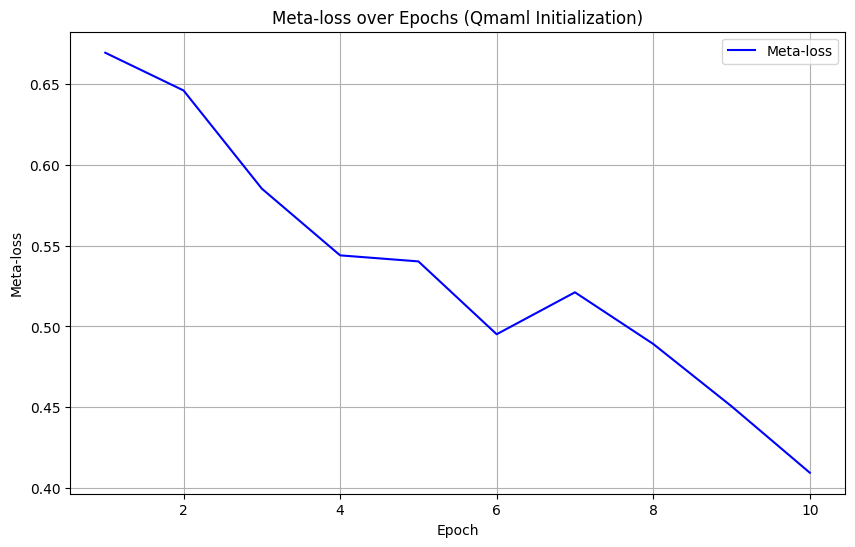

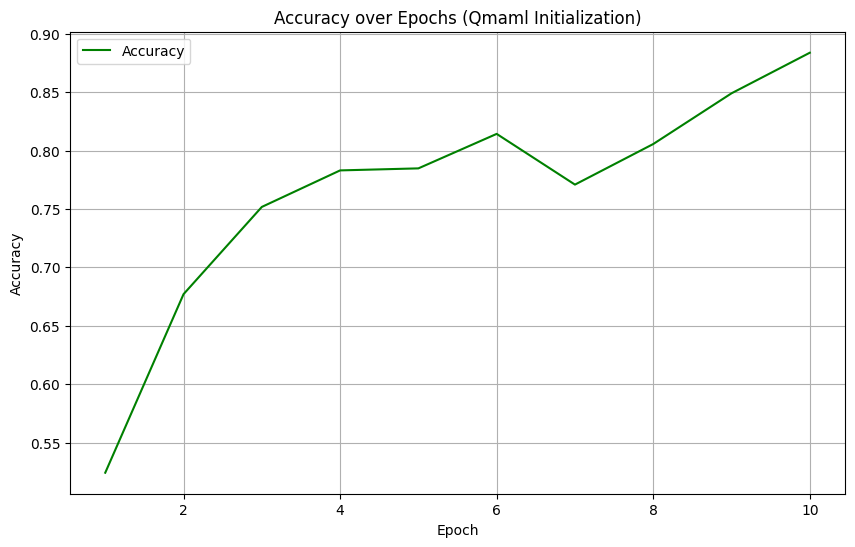

Testing initialization: zero
Epoch 1/10, Meta-loss: 0.6616, Accuracy: 0.5000
Epoch 2/10, Meta-loss: 0.5968, Accuracy: 0.8125
Epoch 3/10, Meta-loss: 0.5414, Accuracy: 0.8698
Epoch 4/10, Meta-loss: 0.5106, Accuracy: 0.8559
Epoch 5/10, Meta-loss: 0.4808, Accuracy: 0.8663
Epoch 6/10, Meta-loss: 0.4735, Accuracy: 0.8750
Epoch 7/10, Meta-loss: 0.4546, Accuracy: 0.8681
Epoch 8/10, Meta-loss: 0.4336, Accuracy: 0.8819
Epoch 9/10, Meta-loss: 0.4156, Accuracy: 0.8837
Epoch 10/10, Meta-loss: 0.4045, Accuracy: 0.8941


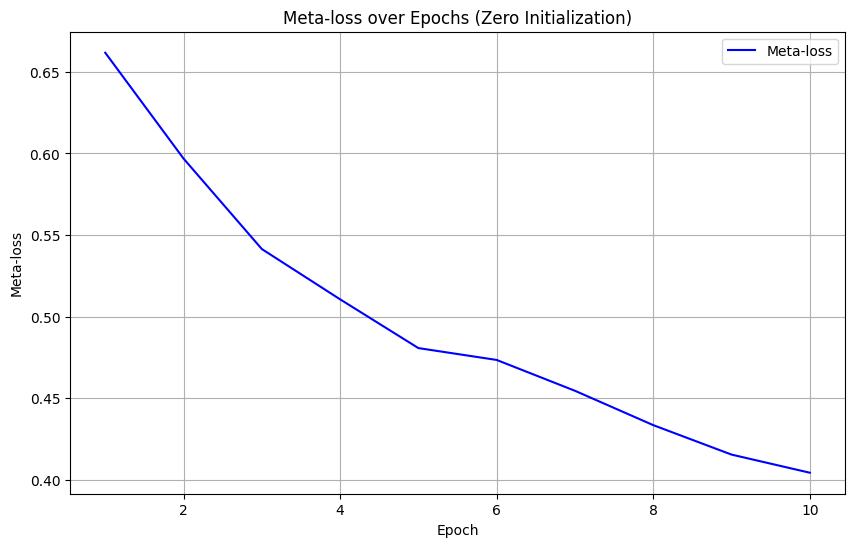

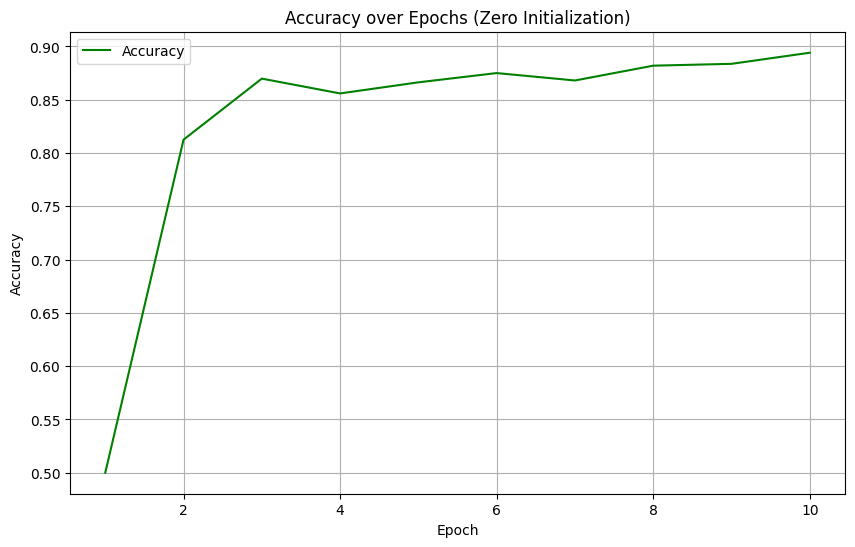

Testing initialization: pi
Epoch 1/10, Meta-loss: 0.7880, Accuracy: 0.5000
Epoch 2/10, Meta-loss: 0.6014, Accuracy: 0.5694
Epoch 3/10, Meta-loss: 0.5292, Accuracy: 0.8438
Epoch 4/10, Meta-loss: 0.4601, Accuracy: 0.9097
Epoch 5/10, Meta-loss: 0.4322, Accuracy: 0.9028
Epoch 6/10, Meta-loss: 0.3963, Accuracy: 0.9115
Epoch 7/10, Meta-loss: 0.3602, Accuracy: 0.9253
Epoch 8/10, Meta-loss: 0.3752, Accuracy: 0.8958
Epoch 9/10, Meta-loss: 0.3897, Accuracy: 0.8733
Epoch 10/10, Meta-loss: 0.3881, Accuracy: 0.8767


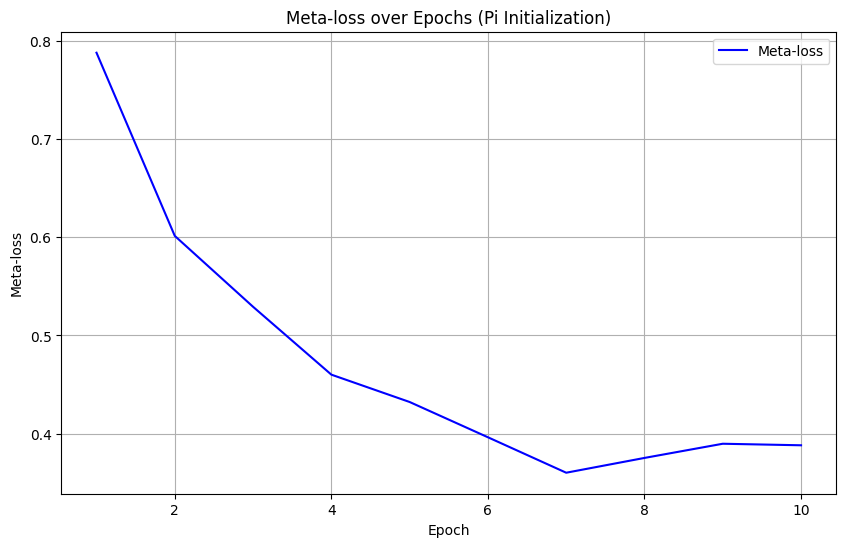

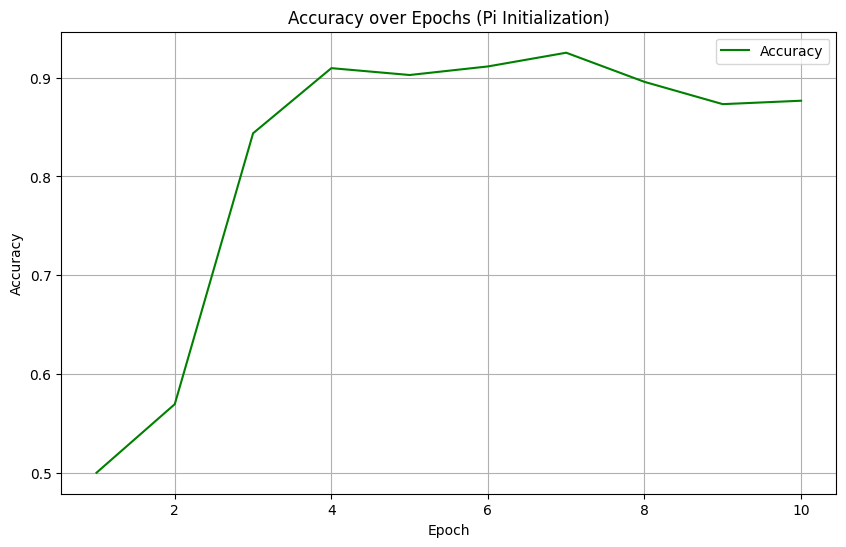

Testing initialization: uniform
Epoch 1/10, Meta-loss: 0.4593, Accuracy: 0.8437
Epoch 2/10, Meta-loss: 0.3923, Accuracy: 0.9028
Epoch 3/10, Meta-loss: 0.3589, Accuracy: 0.9115
Epoch 4/10, Meta-loss: 0.3486, Accuracy: 0.9132
Epoch 5/10, Meta-loss: 0.3426, Accuracy: 0.9045
Epoch 6/10, Meta-loss: 0.3717, Accuracy: 0.8802
Epoch 7/10, Meta-loss: 0.4336, Accuracy: 0.8160
Epoch 8/10, Meta-loss: 0.4331, Accuracy: 0.8299
Epoch 9/10, Meta-loss: 0.3502, Accuracy: 0.8854
Epoch 10/10, Meta-loss: 0.4571, Accuracy: 0.8003


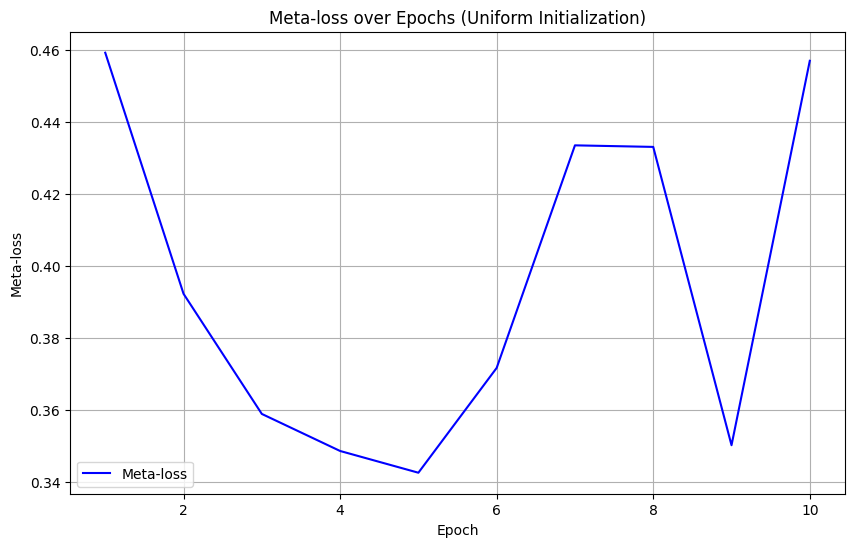

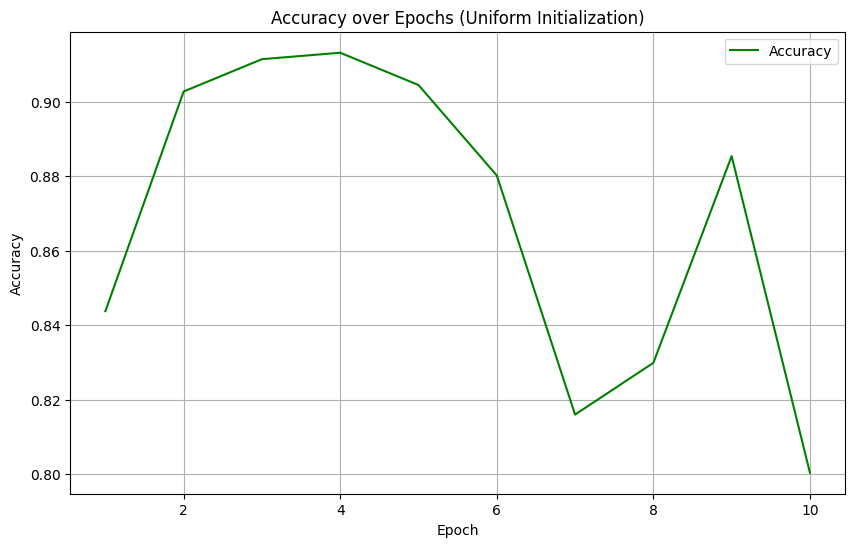

Testing initialization: gaussian
Epoch 1/10, Meta-loss: 0.7120, Accuracy: 0.5000
Epoch 2/10, Meta-loss: 0.6658, Accuracy: 0.5000
Epoch 3/10, Meta-loss: 0.6264, Accuracy: 0.6389
Epoch 4/10, Meta-loss: 0.5888, Accuracy: 0.7622
Epoch 5/10, Meta-loss: 0.5367, Accuracy: 0.8351
Epoch 6/10, Meta-loss: 0.5145, Accuracy: 0.8160
Epoch 7/10, Meta-loss: 0.4679, Accuracy: 0.8628
Epoch 8/10, Meta-loss: 0.4841, Accuracy: 0.8142
Epoch 9/10, Meta-loss: 0.5093, Accuracy: 0.7830
Epoch 10/10, Meta-loss: 0.5370, Accuracy: 0.7708


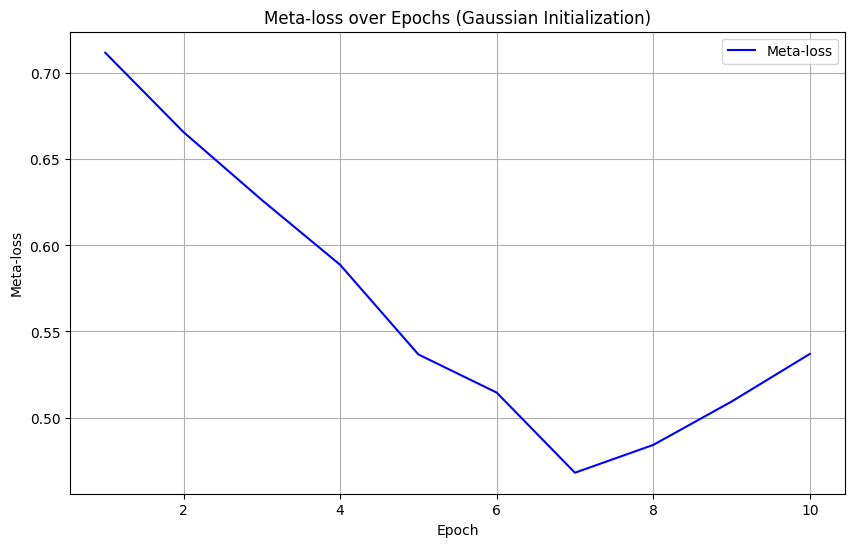

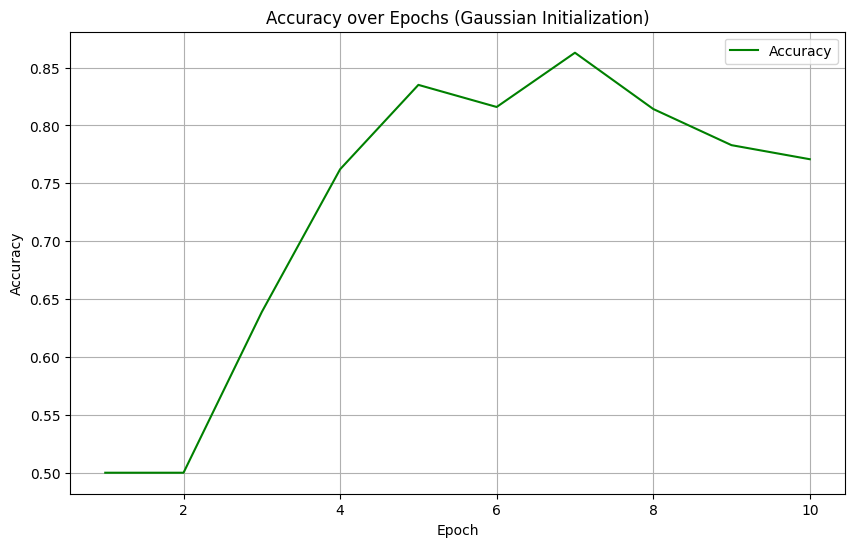

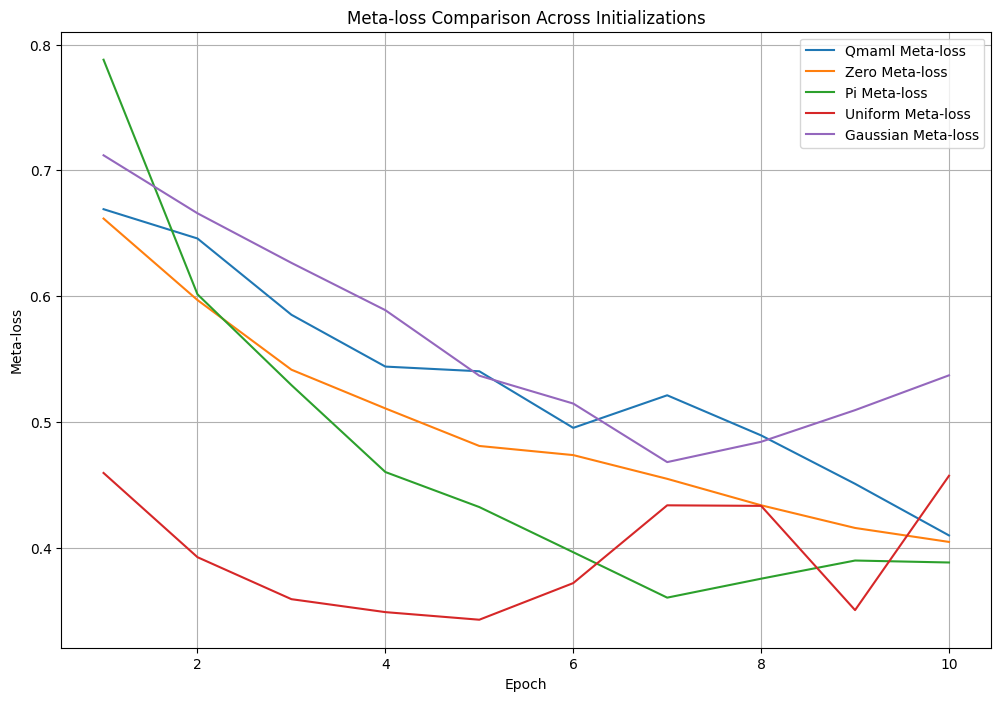

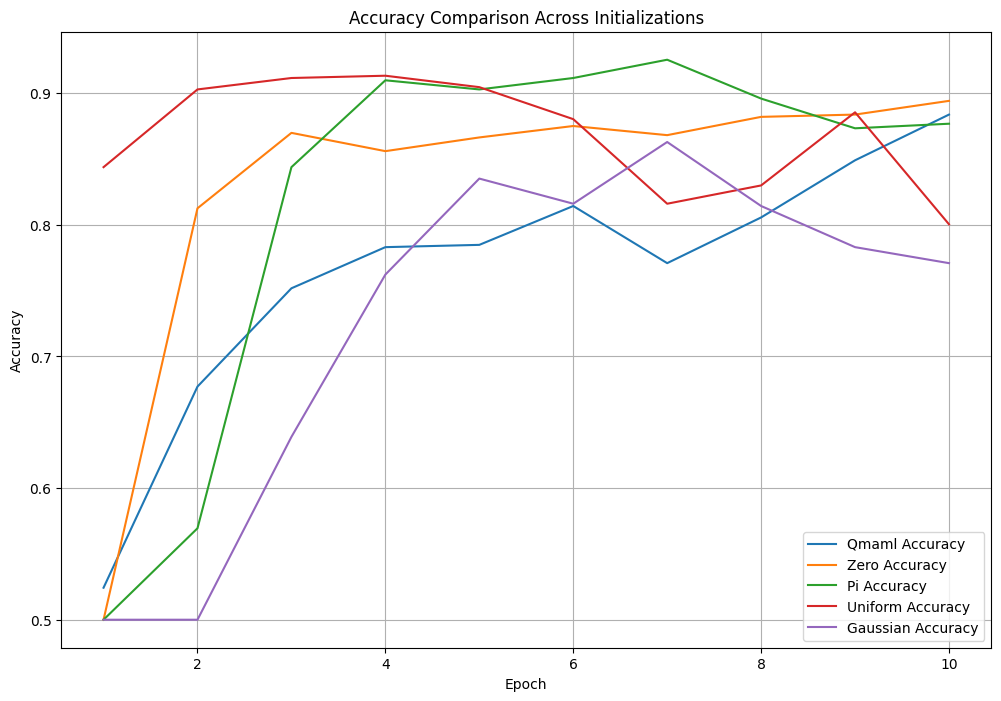

In [18]:
# --- Cell 11: Run Experiments ---
# Test different initialization techniques
initialization_types = ["qmaml", "zero", "pi", "uniform", "gaussian"]
results = {}

for init_type in initialization_types:
    print(f"Testing initialization: {init_type}")

    # Initialize PQC with the current initialization type
    pqc_model = PQCModel(config.NUM_QUBITS, config.Q_DEPTH, init_type=init_type)

    # Combine CNN and PQC into the hybrid model
    hybrid_model = HybridModel(cnn_extractor, pqc_model)

    # Perform meta-training and store results
    training_results = outer_loop_meta_update(hybrid_model, meta_tasks, config.OUTER_LR, config.EVAL_METRICS)
    results[init_type] = training_results

    # Plot training results for the current initialization
    plot_training_results(training_results, init_type)

# Compare results across all initialization techniques
plot_comparison(results)